In [37]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Dataset, Subset, TensorDataset, DataLoader
from random import shuffle
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image


if not torch.cuda.is_available():
    raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

### Arguments

In [38]:
args = {
    'lr': 1e-3,
    'bs': 128,
    'epochs': 5,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50,
    'vae_epochs': 20,
    'n_vae_samples': [6000, 8000, 9000, 9500]
    }

### Data

In [39]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=mean, std=std)
        ])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [40]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

In [41]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


def vae_loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [42]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

## Class incremental model

In [43]:

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
        self.vae.cuda()
        self.vae_optim = torch.optim.Adam(self.vae.parameters())


    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def train_vae(self, data):
        self.vae.train()
        loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)
        for epoch in range(self.args['vae_epochs']):
            vae_train_loss = 0
            for e, (X,_) in enumerate(loader):
              if torch.cuda.is_available():
                X = X.cuda()
              self.vae_optim.zero_grad()

              recon_batch, mu, log_var = self.vae(X)
              loss = vae_loss_function(recon_batch, X, mu, log_var)

              loss.backward()
              vae_train_loss += loss.item()
              self.vae_optim.step()
            print('====> VAE epoch: {} Average loss: {:.4f}'.format(epoch, vae_train_loss / len(loader.dataset)))

    def get_vae_samples(self, num_samples):
        self.vae.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, 2).cuda()
            samples = self.vae.decoder(z)
        return samples

    def train(self):
        for task, data in self.train_datasets.items():
            print(task)
            if int(task) != 0:
              vae_samples = self.get_vae_samples(self.args['n_vae_samples'][int(task)-1]).reshape(-1,1,28,28)
              save_image(vae_samples[:64].view(64,1, 28, 28), './samples/t' + task + '_sample_' + '.png')
              vae_labels = self.model(vae_samples)
              vae_labels = torch.topk(vae_labels, axis=1, k=1)[1].squeeze(1).tolist()
              vae_dataset = CustomDataset(vae_samples.cpu(), vae_labels)

              data = torch.utils.data.ConcatDataset([data, vae_dataset])

            self.train_vae(data)

            loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [44]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

0
====> VAE epoch: 0 Average loss: 187.8608
====> VAE epoch: 1 Average loss: 138.4226
====> VAE epoch: 2 Average loss: 131.6201
====> VAE epoch: 3 Average loss: 129.0759
====> VAE epoch: 4 Average loss: 127.7555
====> VAE epoch: 5 Average loss: 126.8415
====> VAE epoch: 6 Average loss: 126.1136
====> VAE epoch: 7 Average loss: 125.4823
====> VAE epoch: 8 Average loss: 124.7368
====> VAE epoch: 9 Average loss: 124.1441
====> VAE epoch: 10 Average loss: 123.6107
====> VAE epoch: 11 Average loss: 122.8606
====> VAE epoch: 12 Average loss: 122.2774
====> VAE epoch: 13 Average loss: 121.9639
====> VAE epoch: 14 Average loss: 121.4099
====> VAE epoch: 15 Average loss: 120.9593
====> VAE epoch: 16 Average loss: 120.4035
====> VAE epoch: 17 Average loss: 120.1929
====> VAE epoch: 18 Average loss: 119.8306
====> VAE epoch: 19 Average loss: 119.6905
Epoch 0: Loss 0.681 Acc: 0.833
Epoch 1: Loss 0.127 Acc: 0.957
Epoch 2: Loss 0.091 Acc: 0.970
Epoch 3: Loss 0.070 Acc: 0.978
Epoch 4: Loss 0.049 Acc:

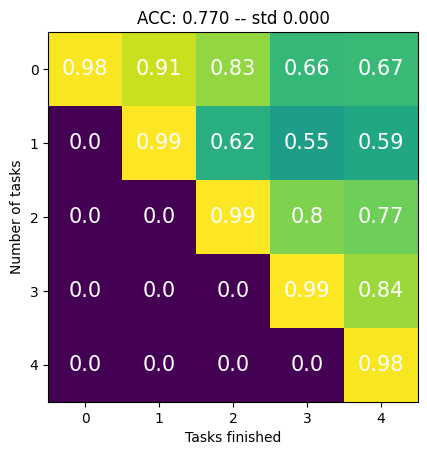

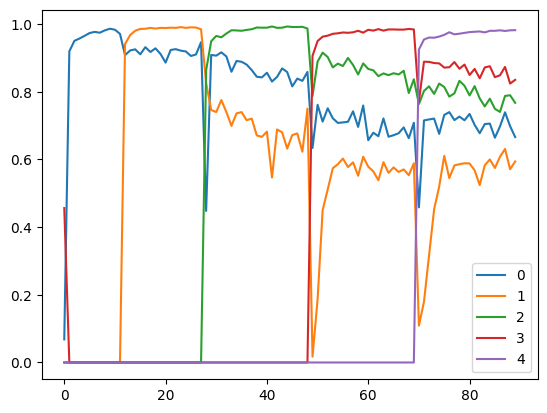

The average accuracy at the end of sequence is: 0.769
BWT:'-0.272'
FWT:'-0.122'


In [45]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")